# Data Loading

In [1]:
# 1) Install Kaggle CLI
!pip -q install kaggle

# 2) Upload small kaggle.json (64 bytes) once per session
from google.colab import files
files.upload()  # pick kaggle.json

# 3) Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4) Download HAM10000 into this session
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content
!unzip -q /content/skin-cancer-mnist-ham10000.zip -d /content/ham10000

# 5) Stable path for your code in this session:
DATA_DIR = "/content/ham10000"
print("DATA_DIR =", DATA_DIR)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:42<00:00, 267MB/s]
100% 5.20G/5.20G [01:42<00:00, 54.4MB/s]
DATA_DIR = /content/ham10000


In [2]:
import pandas as pd
import os, glob

DATA_DIR = "/content/ham10000"
meta = pd.read_csv(os.path.join(DATA_DIR, "HAM10000_metadata.csv"))

print("Total images:", len(meta))
print("Unique labels:", meta.dx.unique())
print(meta.dx.value_counts())


Total images: 10015
Unique labels: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


# Data Exploration and Visualization

nv = Melanocytic nevi
mel = Melanoma
bkl = Benign keratosis
bcc = basal cell carcinoma
akiec = Actinic Keratoses
vasc = Vascular skin lesions
df = Dermatofibroma

In [3]:
# Data structures
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
lesion_types = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

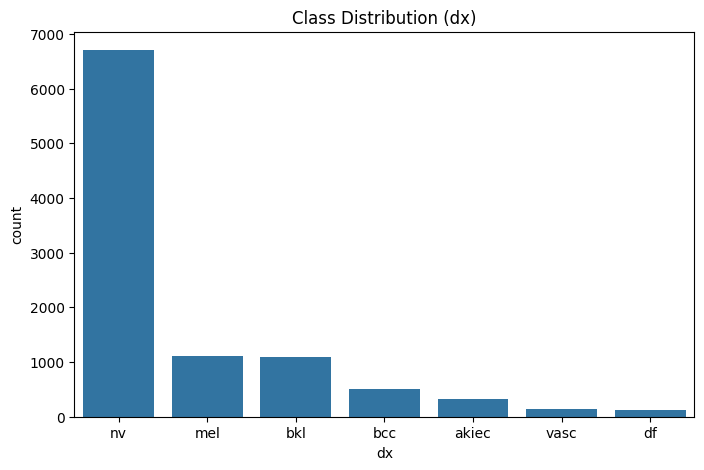

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x="dx", data=meta, order=meta["dx"].value_counts().index)
plt.title("Class Distribution (dx)")
plt.show()


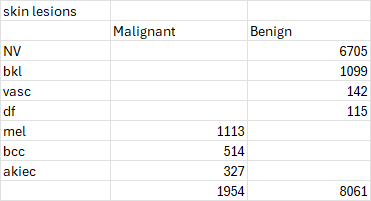

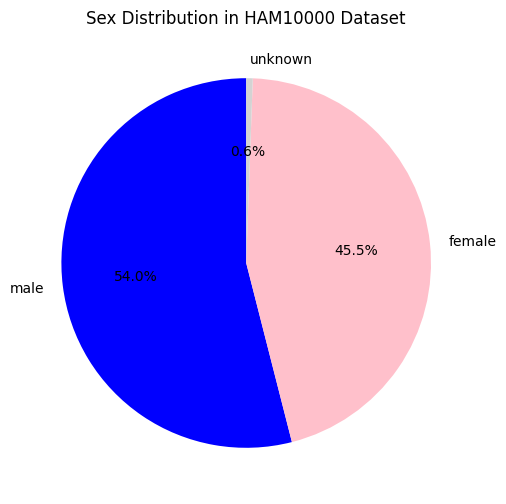

In [6]:
# Count values
sex_counts = meta["sex"].value_counts()

# Plot
plt.figure(figsize=(6,6))
plt.pie(
    sex_counts,
    labels=sex_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["blue", "pink", "lightgray"]  # optional custom colors
)
plt.title("Sex Distribution in HAM10000 Dataset")
plt.show()


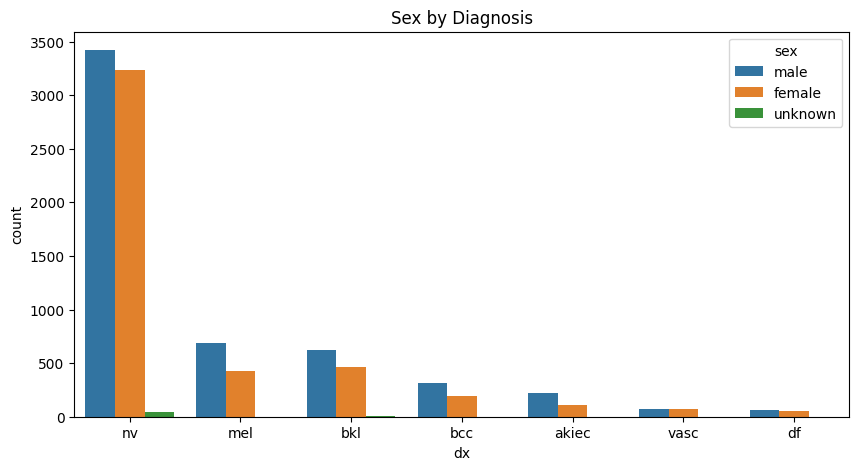

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x="dx", hue="sex", data=meta, order=meta["dx"].value_counts().index)
plt.title("Sex by Diagnosis")
plt.show()


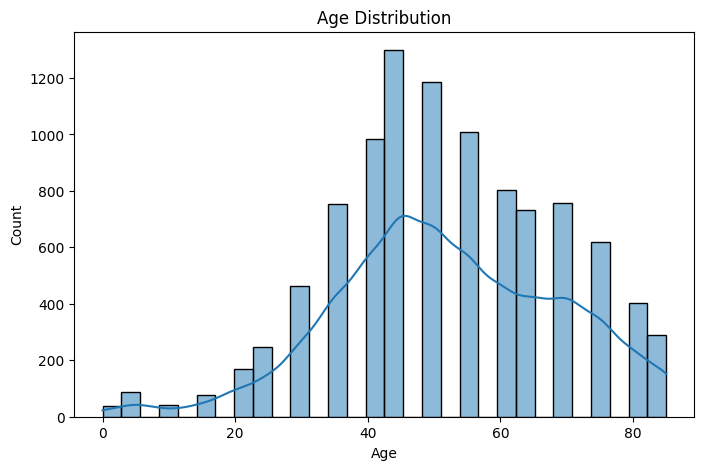

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(meta["age"].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()


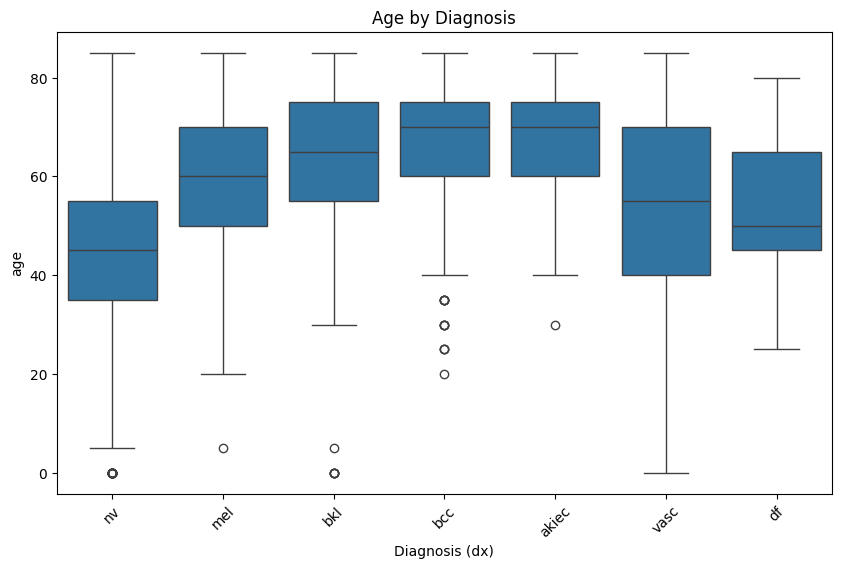

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(x="dx", y="age", data=meta, order=meta["dx"].value_counts().index)
plt.title("Age by Diagnosis")
plt.xlabel("Diagnosis (dx)")
plt.xticks(rotation=45)
plt.show()


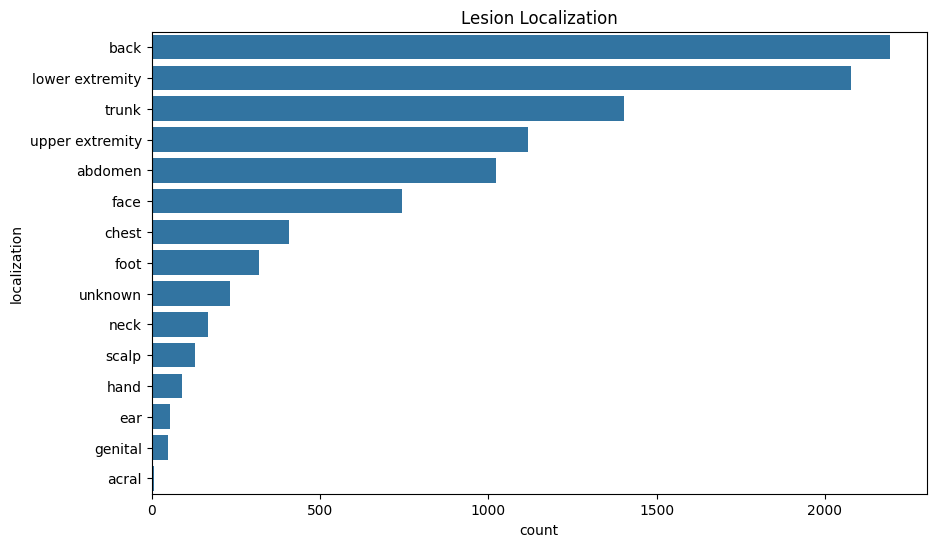

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(y="localization", data=meta, order=meta["localization"].value_counts().index)
plt.title("Lesion Localization")
plt.show()


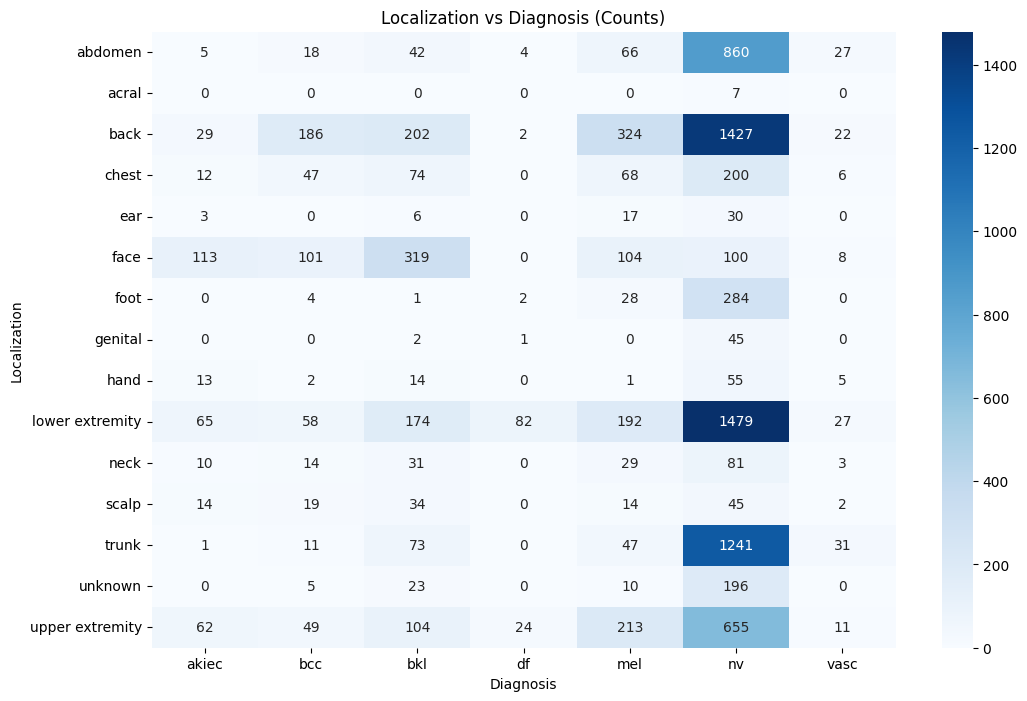

In [11]:
# create crosstab of counts
loc_dx = pd.crosstab(meta["localization"], meta["dx"])

plt.figure(figsize=(12,8))
sns.heatmap(loc_dx, annot=True, fmt="d", cmap="Blues")
plt.title("Localization vs Diagnosis (Counts)")
plt.ylabel("Localization")
plt.xlabel("Diagnosis")
plt.show()


In [12]:
# Count missing values
print(meta.isnull().sum())

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [13]:
# Drop rows where 'age' is missing
meta = meta.dropna(subset=['age']).reset_index(drop=True)

# Verify the result
print(meta.isnull().sum())
print("New dataset size:", meta.shape)


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64
New dataset size: (9958, 7)


In [14]:
print(meta.dx.value_counts())

dx
nv       6660
mel      1111
bkl      1089
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [16]:
import numpy as np
import scipy.stats as stats

meta_age = meta.dropna(subset=["age"]).copy()
# Ensure categorical dtypes (helps with tidy output)
for col in ["dx", "sex", "localization"]:
    meta[col] = meta[col].astype("category")
    meta_age[col] = meta_age[col].astype("category")

# ---------- AGE vs DX ----------
# One-way ANOVA
groups = [g["age"].values for _, g in meta_age.groupby("dx")]
F, p_anova = stats.f_oneway(*groups)

# Effect size: eta-squared (η²) = SSB / SST
grand_mean = meta_age["age"].mean()
ssb = sum(len(g) * (g["age"].mean() - grand_mean) ** 2 for _, g in meta_age.groupby("dx"))
sst = ((meta_age["age"] - grand_mean) ** 2).sum()
eta_sq = ssb / sst

# Nonparametric check (Kruskal–Wallis)
H, p_kw = stats.kruskal(*groups)

print("AGE ~ DX")
print(f"  ANOVA:        F = {F:.3f}, p = {p_anova:.3e}, eta^2 = {eta_sq:.3f}")
print(f"  Kruskal-Wallis: H = {H:.3f}, p = {p_kw:.3e}")
print()

AGE ~ DX
  ANOVA:        F = 470.117, p = 0.000e+00, eta^2 = 0.221
  Kruskal-Wallis: H = 2270.922, p = 0.000e+00



/tmp/ipython-input-1615048288.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g["age"].values for _, g in meta_age.groupby("dx")]
/tmp/ipython-input-1615048288.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ssb = sum(len(g) * (g["age"].mean() - grand_mean) ** 2 for _, g in meta_age.groupby("dx"))


In [17]:
def chi2_cramers_v(df, row, col):
    ct = pd.crosstab(df[row], df[col])
    chi2, p, dof, _ = stats.chi2_contingency(ct)
    n = ct.values.sum()
    # Bias-corrected Cramér’s V (Bergsma, 2013)
    phi2 = chi2 / n
    r, k = ct.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    v = np.sqrt(phi2corr / max((kcorr-1), (rcorr-1)))
    return {"chi2": chi2, "p": p, "dof": dof, "cramers_v": v, "table": ct}

In [18]:
# ---------- SEX vs DX ----------
sex_dx = chi2_cramers_v(meta, "sex", "dx")
print("SEX ~ DX")
print(f"  Chi2 = {sex_dx['chi2']:.3f}, dof = {sex_dx['dof']}, p = {sex_dx['p']:.3e}, Cramér's V = {sex_dx['cramers_v']:.3f}")
print()

# ---------- LOCALIZATION vs DX ----------
loc_dx = chi2_cramers_v(meta, "localization", "dx")
print("LOCALIZATION ~ DX")
print(f"  Chi2 = {loc_dx['chi2']:.3f}, dof = {loc_dx['dof']}, p = {loc_dx['p']:.3e}, Cramér's V = {loc_dx['cramers_v']:.3f}")
print()


SEX ~ DX
  Chi2 = 94.067, dof = 12, p = 8.019e-15, Cramér's V = 0.037

LOCALIZATION ~ DX
  Chi2 = 2814.647, dof = 84, p = 0.000e+00, Cramér's V = 0.140



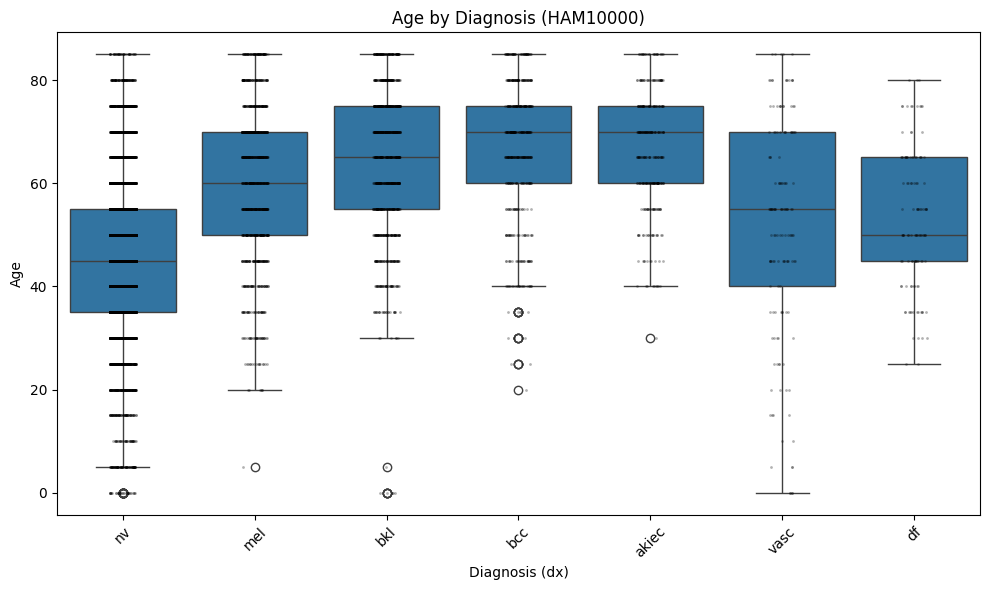

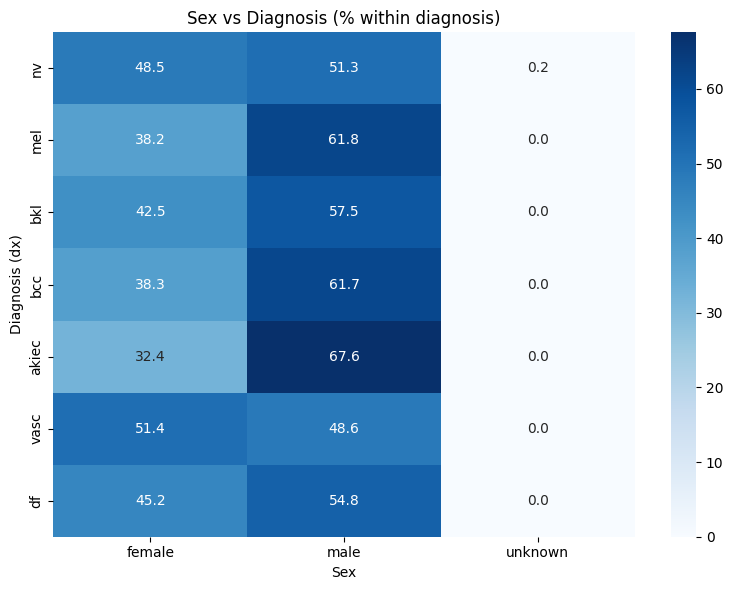

In [19]:
# 1) Age by diagnosis (box + swarm/strip)
plt.figure(figsize=(10,6))
sns.boxplot(x="dx", y="age", data=meta_age, order=meta_age["dx"].value_counts().index)
sns.stripplot(x="dx", y="age", data=meta_age, order=meta_age["dx"].value_counts().index, size=2, color="k", alpha=0.3)
plt.title("Age by Diagnosis (HAM10000)")
plt.xlabel("Diagnosis (dx)")
plt.ylabel("Age")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Sex vs diagnosis – normalized by diagnosis (column-wise %)
sex_ct = pd.crosstab(meta["dx"], meta["sex"], normalize="index") * 100
plt.figure(figsize=(8,6))
sns.heatmap(sex_ct.loc[meta["dx"].value_counts().index], annot=True, fmt=".1f", cmap="Blues")
plt.title("Sex vs Diagnosis (% within diagnosis)")
plt.xlabel("Sex")
plt.ylabel("Diagnosis (dx)")
plt.tight_layout()
plt.show()

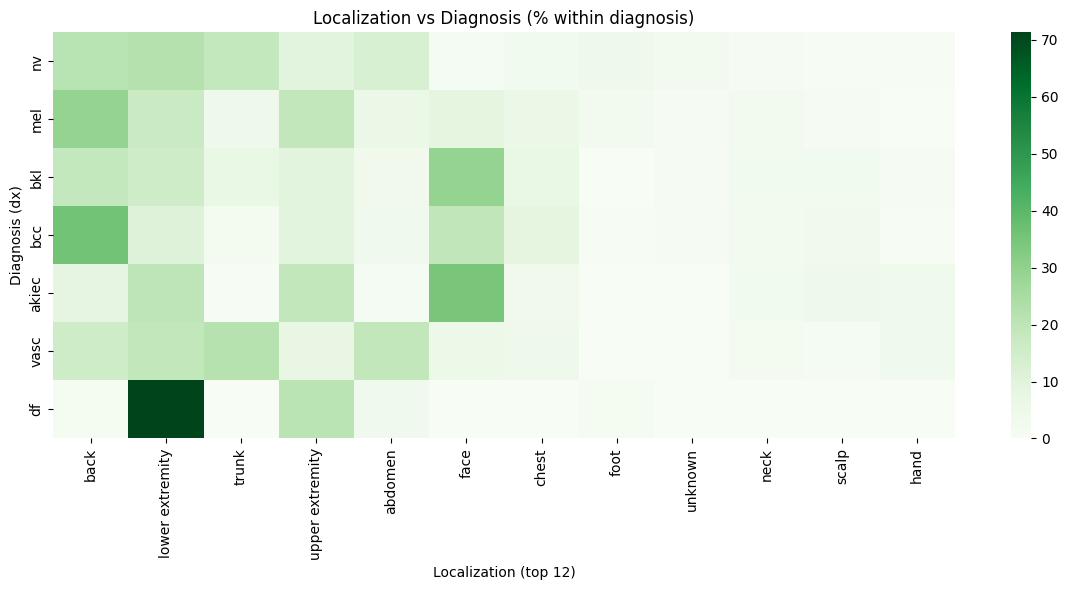

In [20]:
# 3) Localization vs diagnosis – normalized by diagnosis (column-wise %)
loc_ct = pd.crosstab(meta["dx"], meta["localization"], normalize="index") * 100
# Show only the most common localizations to keep plot readable (e.g., top 12)
top_locs = meta["localization"].value_counts().head(12).index
loc_ct = loc_ct[top_locs]

plt.figure(figsize=(12,6))
sns.heatmap(loc_ct.loc[meta["dx"].value_counts().index], annot=False, cmap="Greens")
plt.title("Localization vs Diagnosis (% within diagnosis)")
plt.xlabel("Localization (top 12)")
plt.ylabel("Diagnosis (dx)")
plt.tight_layout()
plt.show()

# Data Preprocessinng


In [34]:
import os

DATA_DIR = "/content/ham10000"

# Count total files
num_files = len(os.listdir(DATA_DIR))
print(f"Total files in {DATA_DIR}: {num_files}")



Total files in /content/ham10000: 9


In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

# Set paths
DATA_DIR = "/content/ham10000"
meta = pd.read_csv(os.path.join(DATA_DIR, "HAM10000_metadata.csv"))
img_dirs = os.path.join(DATA_DIR, "HAM10000_images")

Found 20030 images


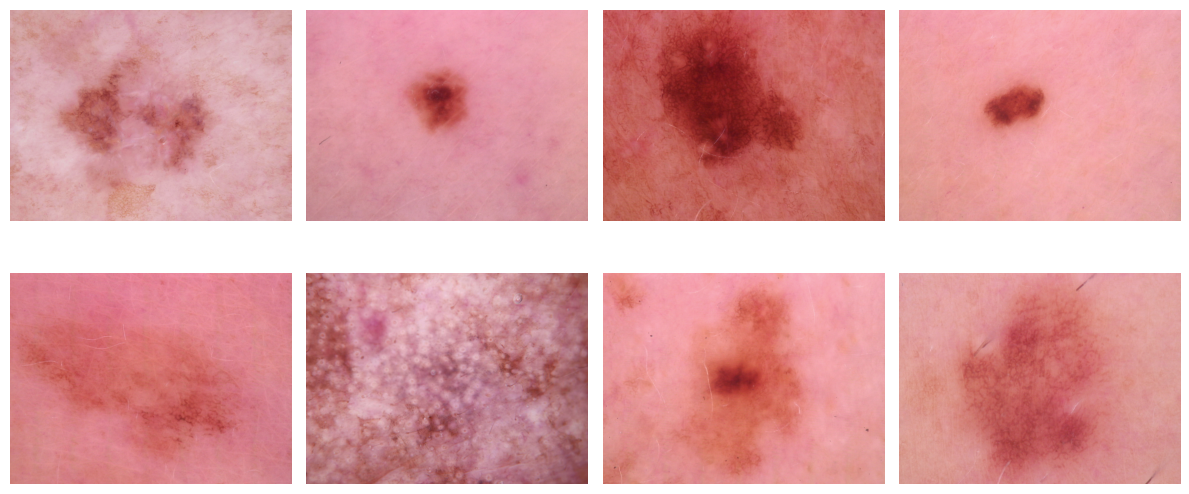

In [41]:

# 🔍 Find all .jpg images recursively
image_paths = []
for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith(".jpg"):
            image_paths.append(os.path.join(root, f))

print(f"Found {len(image_paths)} images")

# 🎲 Pick 8 random images to visualize
sample_images = random.sample(image_paths, 8)

# 🖼️ Display
plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()


Found 20030 images
✅ Resized all images to (224, 224) and saved in /content/ham10000/HAM10000_images_resized


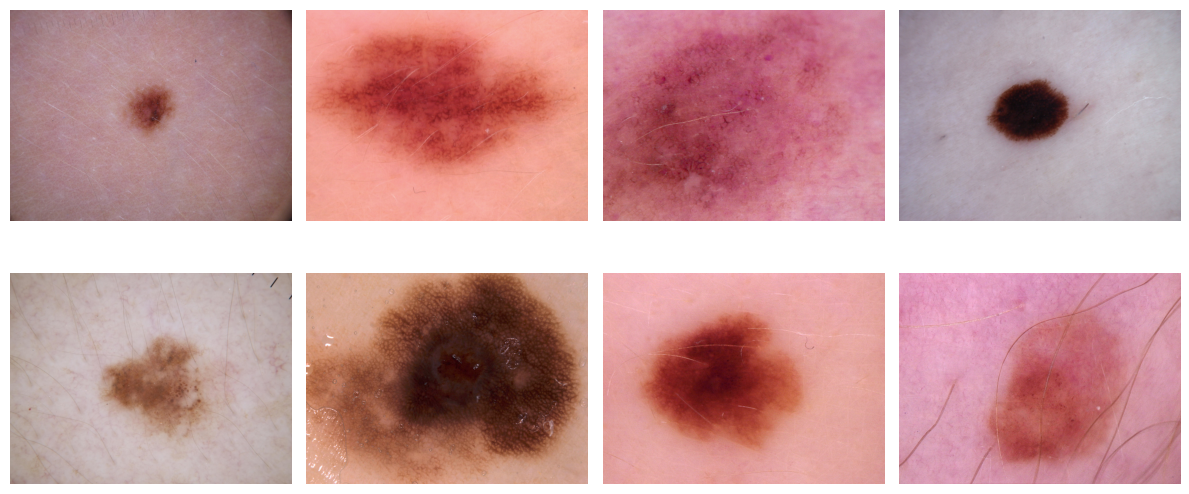

In [42]:
DATA_DIR = "/content/ham10000"
output_dir = os.path.join(DATA_DIR, "HAM10000_images_resized")
os.makedirs(output_dir, exist_ok=True)
target_size = (224, 224)

#Find all .jpg images recursively
image_paths = []
for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith(".jpg"):
            image_paths.append(os.path.join(root, f))

print(f"Found {len(image_paths)} images")

#Resize and save
for img_path in image_paths:
    filename = os.path.basename(img_path)
    try:
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize(target_size, Image.BICUBIC)
        img_resized.save(os.path.join(output_dir, filename))
    except Exception as e:
        print(f"Error resizing {filename}: {e}")

print(f" Resized all images to {target_size} and saved in {output_dir}")

# Visualize 8 random resized images
sample_images = random.sample(image_paths, 8)
plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()


Resized all images to (224, 224) and saved in /content/ham10000/HAM10000_images_resized